En esta práctica se diseñará un algoritmo genético para clasificar los datos de dos bases de datos: tic-tac-toe.data y titanic.data. Durante esta práctica se ha mantenido el enfoque de Pittsburgh, es decir, cada individuo es un conjunto de reglas que clasifica la base de datos. 

Nos ha parecido procedente cambiar el orden de los apartados tal y como se estipulan. En concreto, es más interesante fijar primero los hiperparámetros óptimos (Apartado 3) y después analizar cómo influyen el número de épocas y individuos (Apartado 2). Además, como las ejecuciones son tan costosas se han guardado los resultado en *pickles*. Dichos resultados se irán mostrando a lo largo de la práctica.

A continuación se muestran todas las librerías cargadas, así como los datasets previos cargados:

In [2]:
from Clasificador import AlgoritmoGenetico, ClasificadorNaiveBayes
from Datos import Datos
from EstrategiaParticionado import ValidacionSimple, ValidacionCruzada

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# allNominal: nuevo atributo que fuerza a la clase Datos a interpretar todos los atributos como nominales
dataTitanic = Datos('tic-tac-toe.data',allNominal=True)
dataTic = Datos('tic-tac-toe.data',allNominal=True)

# 1. Detalles de la implementación

Las poblaciones se han definido en nuestro código como un array de individuos, donde cada individuo es un array numPy compuesto de valores booleanos. A continuación, se pasa a describir las características de nuestra implementación en concreto, junto al motivo por el que se han elegido dichas características:

## 1.1. Representación de los individuos

El conjunto de individuos se muestra en un array, ya que en nuestra implementación se ha decidido que el número de reglas debe ser variable, pero siempre fijando el máximo número de reglas que puede tener. De esta forma, limitamos el overfitting que podría surgir porque el algoritmo lograra encontrar suficientes reglas para clasificar bien todo el trainSet. Aunque puede seguir habiendo overfitting, es una buena medida para evitarlo.

Las poblaciones se han definido en nuestro código como un array de individuos, donde cada individuo es un array numPy compuesto de valores booleanos. Estos valores booleanos expresan lo siguiente:
* Cada individuo es un número concreto de reglas que pueden activarse o no.
* Cada regla se activa si cumple una serie de condiciones impuestas a cada atributo. Como todos los atributos son nominales, las condiciones que se imponen son que cierto atributo tenga uno de ciertos valores.
* Si TODAS las condiciones impuestas a cada atributo se cumplen, la regla correspondiente se activa y se mira lo que predice esa regla.
* Una vez tenemos un individuo, cada regla activada del individuo predice una cierta clase para un cierto dato. Si hay una mayoría de predicciones de una clase, no hay discusión: la predicción del individuo es esa clase mayoritaria. Ahora bien, ¿qué pasa si hay empate de predicciones o si ninguna regla ha predicho nada? En tal caso, depende del fin de esa clasificación. Si hemos clasificado un dato para entrenar el algoritmo, estos resultados se marcan siempre como fallo. De esta forma, nos aseguramos de que los individuos tratan de clasificar el mayor número de datos posible de forma correcta. En cambio, en clasificación la predicción es con priores, ya que tratamos de maximizar el número de datos bien clasificados.
* Cada individuo es un array de booleanos, que se puede dividir en reglas de idéntica longitud. A su vez, las reglas se dividen en arrays de booleanos, que corresponden a los atributos de la base de datos. Por ejemplo, si un atributo tiene 2 valores, entonces su array de booleanos correspondiente es de longitud 2, donde un True en la posición i-ésima significa que la regla se activa para un dato solo si tal dato tiene el valor i-ésimo. El último elemento de cada regla corresponde a la predicción que hará si la regla se activa.

## 1.2. Operadores genéticos (cruce y mutación)

La parte más compleja a la hora de trabajar con __cruces__ es que la longitud de los individuos es variable y que los puntos en los que se cruzan los individuos tienen que ser consistentes con las reglas. Para intentar seguir esta política, hemos seguido el siguiente procedimiento en todos los cruces:
1. Se determina cuál es la cadena más larga y se realiza un shuffle de las reglas del individuo. El individuo clasifica exactamente igual, así que no ocurre nada con el individuo a efectos prácticos.
2. Se realiza el cruce correspondiente solamente con la longitud que tienen en común. Es decir, si se va a cruzar un individuo de 2 reglas con uno de 3 reglas, el cruce se realiza teniendo en cuenta solo las 2 primeras reglas de cada individuo, mientras que la tercera regla se añade sin modificaciones a uno de los dos descendientes.

Con esta política se pueden realizar los cruces teniendo en cuenta la longitud variable de las reglas. Además, el primer paso facilita que las últimas reglas sean igual de propensas al cruce que las primeras, ya que si no estarían sujetas a menos cambios. Describamos ahora los tres tipos de cruce siguiendo esta estrategia:
* __Uniforme__: se realiza el cruce tradicional con las primeras reglas tal y como se ha mencionado antes. Después, la parte que no se ha cruzado de la i-ésima regla se añade al i-ésimo descendiente.
* __Un punto__: es como el cruce en un punto tradicional, pero la selección de dicho punto se limita a la longitud del individuo más corto.
* __Dos puntos__: igual que el cruce en un punto, pero ahora seleccionamos dos puntos limitándonos al individuo más corto.

Existen cruces que permitirían modificar la longitud de los descendientes respecto a sus progenitores, ya que aquí se conservan. Es una opción quizá más sofisticada, pero también con una casuística bastante compleja a la hora de implementarla. Por ello, se ha elegido esta opción y dejar la variación de reglas para las mutaciones.

Respecto a las __mutaciones__, se han incluido dos tipos, cada una con su propia probabilidad de ocurrencia:
* En la primera, se realiza una mutación tradicional bit a bit en los individuos. Esta opción es menos invasiva y por tanto ocurre más a menudo.
* En la segunda, se decide a cara o cruz si se quita una regla o se añade una nueva regla generada aleatoriamente (siempre que el número de reglas del individuo lo permita). De esta forma, tenemos controlado que los individuos tengan la oportunidad de alcanzar un número óptimo de reglas, ya que los cruces no permiten un cambio en el número de reglas. Al ser una política más invasiva, debería ocurrir con menos frecuencia. Sin embargo, también debemos recordar que el primero es bit a bit y el segundo es por individuos, por lo que aunque la segunda probabilidad sea más grande es posible que siga teniendo más tasa de ocurrencia la primera mutación.

## 1.3. Fitness de un individuo

Respecto al Fitness no daban lugar a la elección, ya que se nos indicaba en la documentación de la práctica. Ya se ha mostrado cómo un individuo predice una cierta clase para un cierto dato en el apartado 1.1. Ahora, el fitness consiste únicamente en ver la tasa de aciertos de esas predicciones evaluando todo el trainSet.

# 2. Análisis de los hiperparámetros

En primer lugar, se ha querido decidir el valor óptimo de los siguientes hiperparámetros (probando con los valores que se muestran):
* __Probabilidad de mutación bit a bit__: 0.001,0.005,0.01,0.05,0.1
* __Probabilidad de mutación de reglas__: 0.01,0.02,0.05,0.1
* __Número máximo de reglas__: 2,3,4,5,6,7,10,15
* __Tipo de cruce__: uniforme, en un punto, en dos puntos

Aunque existe una cierta dependencia entre los parámetros, __es razonable asumir independencia__ entre ellos. Esto es debido a que cada ejecución del algoritmo en tic-tac-toe con 50 individuos y 100 épocas cuesta unos 5 minutos. Vamos a realizar una validación cruzada con 5 particiones, así que cada validación tarda 25 minutos. Si no suponemos independencia, tendremos que realizar 5\*4\*5\*3=300 ejecuciones, lo que significa que tendríamos que ejecutar el programa durante 125 horas, es decir, más de 5 días. No nos parecía un tiempo razonable solamente para tic-tac-toe, por lo que asumiendo independencia ahora tendremos que realizar 5+4+5+3=17 ejecuciones, por lo que la ejecución del programa es de 7 horas. Al asumir independencia, podemos fijar unos parámetros mientras fluctuamos uno de ellos.

Tras esto, debemos indicar los valores predeterminados que se utilizarán en los demás hiperparámetros mientras variamos uno de ellos:
* __Probabilidad de mutación bit a bit__: 0.01
* __Probabilidad de mutación de reglas__: 0.05
* __Número máximo de reglas__: 4
* __Tipo de cruce__: en un punto

Pasamos a mostrar los resultados que obtuvimos en cada dataset:

In [12]:
# Código previo
titanicPath = './titanic/'
ticPath = './tictactoe/'


# Realiza validación cruzada con una serie de hiperparámetros en concreto.
# Tras hacerlo, guarda en un pickle una tabla Pandas donde en cada fila se
# indica el valor del hiperparámetro, la media del error de validación,
# su desviación típica y el número de particiones que se han probado
# df: DataFrame que se devolverá con los datos añadidos. Si es None se crea uno nuevo
# dataset: clase Datos con los datos correspondientes
# lambdaFunc: función lambda compuesta por el init del algoritmo, donde el único parmámetro
# de la lambda es el hiperparámetro en cuestión
# params: posibles valores del hiperparámetro
# numPart: particiones que va a tener la validación cruzada
# paramName: nombre del parámetro (para crear el pickle con su nombre)
def valPickle(dataset,lambdaFunc,params,numPart,paramName,df=None):
    if df is None:
        df = pd.DataFrame(columns=['Param','Mean','Std','NumEx'])
    
    val = ValidacionCruzada(numPart)
    for i,param in enumerate(params):
        alg = lambdaFunc(param)
        errs = alg.validacion(val,dataset)
        mean = np.mean(errs)
        std = np.std(errs)
        df = df.append({'Param':param,
                   'Mean':mean,
                   'Std':std,
                   'NumEx':numPart},ignore_index=True)
        print(df)
    df.to_pickle(str(paramName) + '.pkl')

def printPickle(path,name):
    df = pd.read_pickle(path+name+'.pkl')
    print(df)

In [ ]:
# Código de ejemplo que se realiza para hallar cada tabla para un hiperparámetro concreto
func = lambda x: AlgoritmoGenetico(probMutacionBit=x)
params = [0.001,0.005,0.01,0.05,0.1]
valPickle(dataTic,func,params,5,'mutacionBit')

## 2.1. Titanic

Probabilidad de mutación bit a bit:

In [13]:
printPickle(titanicPath,'mutacionBit')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0  0.001  0.228512  0.022726    5.0
1           1  0.005  0.212221  0.012766    5.0
2           2  0.010  0.223741  0.025446    5.0
3           3  0.050  0.223732  0.024091    5.0
4           4  0.100  0.219863  0.025643    5.0


Probabilidad de mutación del individuo (añadir o quitar reglas):

In [14]:
printPickle(titanicPath,'mutacionInd')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0   0.01  0.224694  0.018700    5.0
1           1   0.02  0.222739  0.011647    5.0
2           2   0.05  0.218000  0.026151    5.0
3           3   0.10  0.216058  0.022492    5.0


Máximo de reglas permitidas en un individuo:

In [15]:
printPickle(titanicPath,'maxReglas')

   Unnamed: 0  Param      Mean       Std  NumEx
0           0    2.0  0.217020  0.025083    5.0
1           1    3.0  0.221823  0.021541    5.0
2           2    4.0  0.218929  0.052359    5.0
3           3    5.0  0.216988  0.023242    5.0
4           4    6.0  0.222720  0.038244    5.0
5           5    7.0  0.218911  0.018758    5.0
6           6   10.0  0.218004  0.028200    5.0
7           7   15.0  0.215097  0.033228    5.0


Política de cruce elegida:

In [16]:
printPickle(titanicPath,'cruces')

   Unnamed: 0      Param      Mean       Std  NumEx
0           0   uniforme  0.226594  0.015820      5
1           1    unPunto  0.210330  0.015197      5
2           2  dosPuntos  0.221800  0.015343      5


## 2.2. Tic-Tac-Toe

Probabilidad de mutación bit a bit:

In [17]:
printPickle(ticPath,'mutacionBit')

   Param      Mean       Std  NumEx
0  0.001  0.346510  0.027139    5.0
1  0.005  0.346462  0.027035    5.0
2  0.010  0.337329  0.061509    5.0
3  0.050  0.346640  0.030919    5.0
4  0.100  0.346559  0.030422    5.0


Aún con mayor desviación típica, es la probabilidad de mutación bit a bit 1% la que parece manejar mejores resultados. Por ello, se elige como hiperparámetro.

Probabilidad de mutación del individuo (añadir o quitar reglas):

In [18]:
printPickle(ticPath,'mutacionInd')

   Param      Mean       Std  NumEx
0   0.01  0.346591  0.012126    5.0
1   0.02  0.346527  0.020753    5.0
2   0.05  0.346527  0.021275    5.0
3   0.10  0.346851  0.054311    5.0


Aquí, dentro de los valores tratados las medias son idénticas y las desviaciones típicas (quitando el 10%) no parecen significativamente distintas. Por ello, nos quedamos con un valor intermedio: 5%.

Máximo de reglas permitidas en un individuo:

In [19]:
printPickle(ticPath,'maxReglas')

   Param      Mean       Std  NumEx
0    2.0  0.346559  0.019423    5.0
1    3.0  0.346446  0.047460    5.0
2    4.0  0.346591  0.010684    5.0
3    5.0  0.346608  0.031996    5.0
4    6.0  0.346559  0.046759    5.0
5    7.0  0.346543  0.019125    5.0
6   10.0  0.346721  0.035540    5.0
7   15.0  0.346591  0.044845    5.0


Parece que el error no cambia demasiado con el número de reglas elegidas. Esto puede ser un indicador de que los algoritmos genéticos de Pittsburgh quizá no sean capaces de clasificar correctamente esta base de datos. Basándonos en la desviación típica y en que queremos que el algoritmo genético tenga una buena capacidad de expresión, nos quedamos con un número máximo de 7 reglas.

Política de cruce elegida:

In [20]:
printPickle(ticPath,'cruces')

       Param      Mean       Std NumEx
0   uniforme  0.346446  0.034480     5
1    unPunto  0.345658  0.046954     5
2  dosPuntos  0.346397  0.032197     5


Aunque los resultados son muy similares, parece que ha ido un poco mejor el cruce en un punto. Nos quedamos con él.

# 3. Resultados de clasificación

En este apartado se va a valorar qué cantidad de individuos en la población se debe utilizar, así como cantidad de épocas. En primer lugar, se realizará una fase de validación cruzada como en el apartado anterior, donde veamos qué valores son mejores. En concreto, se nos ha mandado probar con 50 y 150 individuos por población y con 100 y 200 épocas. Esto hace un total de 4 valdaciones distintas. Veremos en primer lugar la tabla, donde los valores indicados corresponden a [epoca,individuos]. Una vez se halle la mejor combinación, se procederá a realizar una validación simple de una ejecución para ver cuál es el mejor individuo resultante y se analizará en profundidad. 

## 3.1. Titanic

Primero se muestra la tabla de medias de error:

In [ ]:
# Código ejecutado (tarda mucho, aviso)
func = lambda x: AlgoritmoGenetico(poblacion=x[0],epochs=x[1],maxReglas=7)
pobl = [50,150]
ep = [100,200]
params = []
for e in ep:
    for p in pobl:
        params.append([p,e])

valPickle(dataTitanic,func,params,5,'poblacion')

In [21]:
printPickle(titanicPath,'poblacion')

   Unnamed: 0       Param      Mean       Std  NumEx
0           0   [50, 100]  0.227555  0.020200      5
1           1  [150, 100]  0.218925  0.038056      5
2           2   [50, 200]  0.217011  0.028430      5
3           3  [150, 200]  0.206489  0.014451      5


## 3.2. Tic-Tac-Toe

Primero se muestra la tabla de medias de error:

In [ ]:
# Código ejecutado (tarda mucho, aviso)
func = lambda x: AlgoritmoGenetico(poblacion=x[0],epochs=x[1],maxReglas=7)
pobl = [50,150]
ep = [100,200]
params = []
for e in ep:
    for p in pobl:
        params.append([p,e])

valPickle(dataTic,func,params,5,'poblacion')

In [23]:
printPickle(ticPath,'poblacion')

        Param      Mean       Std NumEx
0   [50, 100]  0.345480  0.031039     5
1  [150, 100]  0.346608  0.023732     5
2   [50, 200]  0.342403  0.009133     5
3  [150, 200]  0.346235  0.062793     5


Como vemos, aunque todos oscilan en torno al 34%, el que mejor parece que sale según la media es [50,200]. Además, tiene la desviación típica más baja con mucha diferencia, así que será el que finalmente elijamos. 

Es curioso observar el que debería ser mejor, [150,200]. Parece ser que ya empieza a haber algo de overfitting en este punto, ya que la media asciende y la desviación típica es la más alta de todas.

Ahora, vamos a correr validación simple con una ejecución para ver el individuo obtenido y analizarlo:

In [24]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(poblacion=50,epochs=200,maxReglas=7)
errs = alg.validacion(val,dataTic)

Época:  0
Fitness medio:  0.0029227557411273487
Fitness del mejor individuo:  0.04175365344467641
Época:  1
Fitness medio:  0.01661795407098121
Fitness del mejor individuo:  0.05845511482254697
Época:  2
Fitness medio:  0.03127348643006263
Fitness del mejor individuo:  0.35490605427974947
Época:  3
Fitness medio:  0.08918580375782881
Fitness del mejor individuo:  0.36325678496868474
Época:  4
Fitness medio:  0.16647181628392485
Fitness del mejor individuo:  0.3674321503131524
Época:  5
Fitness medio:  0.24137787056367435
Fitness del mejor individuo:  0.3674321503131524
Época:  6
Fitness medio:  0.28196242171189984
Fitness del mejor individuo:  0.3757828810020877
Época:  7
Fitness medio:  0.3027974947807934
Fitness del mejor individuo:  0.40083507306889354
Época:  8
Fitness medio:  0.25741127348643006
Fitness del mejor individuo:  0.40501043841336115
Época:  9
Fitness medio:  0.2781210855949896
Fitness del mejor individuo:  0.40501043841336115
Época:  10
Fitness medio:  0.30375782881002

Época:  41
Fitness medio:  0.40906054279749476
Fitness del mejor individuo:  0.6430062630480167
Época:  42
Fitness medio:  0.4204175365344468
Fitness del mejor individuo:  0.6430062630480167
Época:  43
Fitness medio:  0.432526096033403
Fitness del mejor individuo:  0.6430062630480167
Época:  44
Fitness medio:  0.44292275574112727
Fitness del mejor individuo:  0.6492693110647182
Época:  45
Fitness medio:  0.4342379958246347
Fitness del mejor individuo:  0.6492693110647182
Época:  46
Fitness medio:  0.43703549060542796
Fitness del mejor individuo:  0.6576200417536534
Época:  47
Fitness medio:  0.4433402922755741
Fitness del mejor individuo:  0.6576200417536534
Época:  48
Fitness medio:  0.40776617954070987
Fitness del mejor individuo:  0.6576200417536534
Época:  49
Fitness medio:  0.42158663883089775
Fitness del mejor individuo:  0.6576200417536534
Época:  50
Fitness medio:  0.4760751565762004
Fitness del mejor individuo:  0.6576200417536534
Época:  51
Fitness medio:  0.45553235908141965

Época:  82
Fitness medio:  0.49640918580375787
Fitness del mejor individuo:  0.7223382045929019
Época:  83
Fitness medio:  0.5271816283924843
Fitness del mejor individuo:  0.7223382045929019
Época:  84
Fitness medio:  0.5067223382045928
Fitness del mejor individuo:  0.7265135699373695
Época:  85
Fitness medio:  0.5011691022964508
Fitness del mejor individuo:  0.7265135699373695
Época:  86
Fitness medio:  0.5215866388308976
Fitness del mejor individuo:  0.7265135699373695
Época:  87
Fitness medio:  0.5456784968684759
Fitness del mejor individuo:  0.7265135699373695
Época:  88
Fitness medio:  0.5491022964509394
Fitness del mejor individuo:  0.7265135699373695
Época:  89
Fitness medio:  0.5289770354906055
Fitness del mejor individuo:  0.7265135699373695
Época:  90
Fitness medio:  0.587223382045929
Fitness del mejor individuo:  0.7265135699373695
Época:  91
Fitness medio:  0.5928601252609603
Fitness del mejor individuo:  0.7265135699373695
Época:  92
Fitness medio:  0.5377453027139875
Fitn

Época:  123
Fitness medio:  0.5113987473903967
Fitness del mejor individuo:  0.755741127348643
Época:  124
Fitness medio:  0.4798329853862214
Fitness del mejor individuo:  0.755741127348643
Época:  125
Fitness medio:  0.4878914405010439
Fitness del mejor individuo:  0.755741127348643
Época:  126
Fitness medio:  0.506597077244259
Fitness del mejor individuo:  0.755741127348643
Época:  127
Fitness medio:  0.4684342379958246
Fitness del mejor individuo:  0.755741127348643
Época:  128
Fitness medio:  0.5000417536534447
Fitness del mejor individuo:  0.755741127348643
Época:  129
Fitness medio:  0.5455114822546973
Fitness del mejor individuo:  0.755741127348643
Época:  130
Fitness medio:  0.5251356993736952
Fitness del mejor individuo:  0.755741127348643
Época:  131
Fitness medio:  0.5112317327766179
Fitness del mejor individuo:  0.755741127348643
Época:  132
Fitness medio:  0.4648851774530271
Fitness del mejor individuo:  0.755741127348643
Época:  133
Fitness medio:  0.4939457202505219
Fitn

Época:  164
Fitness medio:  0.5262212943632567
Fitness del mejor individuo:  0.7599164926931107
Época:  165
Fitness medio:  0.542839248434238
Fitness del mejor individuo:  0.7599164926931107
Época:  166
Fitness medio:  0.5662630480167015
Fitness del mejor individuo:  0.7599164926931107
Época:  167
Fitness medio:  0.576910229645094
Fitness del mejor individuo:  0.7599164926931107
Época:  168
Fitness medio:  0.5952818371607516
Fitness del mejor individuo:  0.7661795407098121
Época:  169
Fitness medio:  0.5333611691022964
Fitness del mejor individuo:  0.7661795407098121
Época:  170
Fitness medio:  0.5861795407098122
Fitness del mejor individuo:  0.7661795407098121
Época:  171
Fitness medio:  0.6139874739039666
Fitness del mejor individuo:  0.7661795407098121
Época:  172
Fitness medio:  0.6158246346555323
Fitness del mejor individuo:  0.7661795407098121
Época:  173
Fitness medio:  0.5508559498956158
Fitness del mejor individuo:  0.7661795407098121
Época:  174
Fitness medio:  0.519457202505

Primero, mostramos el individuo separado por reglas:

In [26]:
lenRegla = alg.lenRegla
ind = alg.individuo

numReglas = int(len(ind)/lenRegla)
for i in range(numReglas):
    print('Regla',i)
    print(ind[i*lenRegla:(i+1)*lenRegla])

Regla 0
[ True  True  True False  True  True  True False  True  True  True  True
 False False  True  True  True  True  True False  True  True False  True
  True  True  True  True]
Regla 1
[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True False  True False False  True
 False False  True  True]
Regla 2
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True False False  True  True  True  True False
  True  True  True  True]
Regla 3
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True False
  True  True  True  True]
Regla 4
[ True  True  True False False  True False  True  True  True  True  True
 False False  True  True  True  True False  True  True False  True  True
  True  True  True  True]
Regla 5
[ True  True  True  True  True  True  True False  True False  True  True
 False False  True 

Como vemos, en este caso solo se han mostrado 6 reglas de las 7 que se permitían, mostrando así que no ha necesitado su máxima expresión. Para ayudarnos a entender el significado de cada regla, mostramos el diccionario de datos:

In [27]:
print(dataTic.diccionario)

[{'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'negative': 0, 'positive': 1}]


Todos los atributos tienen tres valores: b,o,x (en este orden). Analicemos por tanto lo que significan las reglas. Separemos por ejemplo la Regla 0 por atributos:

In [28]:
regla = ind[0:lenRegla]
numAtributos = int((lenRegla-1)/3)
for i in range(0,numAtributos):
    print('Atributo',i)
    print(regla[i*3:(i+1)*3])
print('\nPredicción:',regla[-1])

Atributo 0
[ True  True  True]
Atributo 1
[False  True  True]
Atributo 2
[ True False  True]
Atributo 3
[ True  True  True]
Atributo 4
[False False  True]
Atributo 5
[ True  True  True]
Atributo 6
[ True False  True]
Atributo 7
[ True False  True]
Atributo 8
[ True  True  True]

Predicción: True


El hecho de que la predicción sea True significa que, en caso de que cumpla las condiciones impuestas en cada atributo, la predicción será 1 (según el diccionario, Positive). 

Ahora veamos cuáles son esas condiciones impuestas por cada atributo. El array del atributo 0 es [ True  True  True], es decir, para tener esta regla en cuenta para un cierto dato debemos tener en el primer atributo b,o,x, es decir, siempre se cumple esta condición. El segundo atributo es [False  True  True]. Según esto, solo debemos tener esta regla en cuenta si nuestro dato tiene en el segundo atributo el valor o,x. Por ejemplo, en el tercero debería tener los valores b,x y así sucesivamente. 

Para que esta regla se 'active', se deben de tener en cuenta todas estas condiciones, ya que todas deben cumplirse. Al mirarse todas las 'reglas' activadas, se elije democráticamente la predicción. Ante el empate se elige el prior.

Ahora analicemos un hecho curioso que cumplen todas las reglas: todas predicen True. Además, veamos cuál es el prior en este caso:

In [29]:
print('Prior:',alg.prior)

Prior: 1


Al ser el prior True y predecir todas las reglas True, vemos que la predicción de este algoritmo siempre es True. Parece que definitivamente el algoritmo genético no es la mejor forma de clasificar esta base de datos. Probemos a ejecutar el algoritmo con un número máximo de reglas que claramente va a causar overfitting, 30 reglas:

In [32]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(maxReglas=30)
alg.validacion(val,dataTic)

Época:  0
Fitness medio:  0.01962421711899791
Fitness del mejor individuo:  0.3465553235908142
Época:  1
Fitness medio:  0.10467640918580376
Fitness del mejor individuo:  0.3883089770354906
Época:  2
Fitness medio:  0.22580375782881007
Fitness del mejor individuo:  0.3966597077244259
Época:  3
Fitness medio:  0.2839665970772443
Fitness del mejor individuo:  0.3966597077244259
Época:  4
Fitness medio:  0.28242171189979126
Fitness del mejor individuo:  0.3966597077244259
Época:  5
Fitness medio:  0.32601252609603343
Fitness del mejor individuo:  0.4091858037578288
Época:  6
Fitness medio:  0.2688935281837161
Fitness del mejor individuo:  0.4091858037578288
Época:  7
Fitness medio:  0.28334029227557417
Fitness del mejor individuo:  0.4091858037578288
Época:  8
Fitness medio:  0.27724425887265136
Fitness del mejor individuo:  0.4091858037578288
Época:  9
Fitness medio:  0.27402922755741127
Fitness del mejor individuo:  0.4091858037578288
Época:  10
Fitness medio:  0.254070981210856
Fitness

Época:  41
Fitness medio:  0.5282254697286013
Fitness del mejor individuo:  0.6680584551148225
Época:  42
Fitness medio:  0.4795407098121086
Fitness del mejor individuo:  0.6722338204592901
Época:  43
Fitness medio:  0.47515657620041757
Fitness del mejor individuo:  0.6951983298538622
Época:  44
Fitness medio:  0.47407098121085595
Fitness del mejor individuo:  0.6951983298538622
Época:  45
Fitness medio:  0.4694780793319416
Fitness del mejor individuo:  0.6951983298538622
Época:  46
Fitness medio:  0.45052192066805846
Fitness del mejor individuo:  0.697286012526096
Época:  47
Fitness medio:  0.4594989561586638
Fitness del mejor individuo:  0.7223382045929019
Época:  48
Fitness medio:  0.4935281837160752
Fitness del mejor individuo:  0.7223382045929019
Época:  49
Fitness medio:  0.4924425887265136
Fitness del mejor individuo:  0.7223382045929019
Época:  50
Fitness medio:  0.5005010438413361
Fitness del mejor individuo:  0.7223382045929019
Época:  51
Fitness medio:  0.4917327766179541
Fi

Época:  82
Fitness medio:  0.5879331941544885
Fitness del mejor individuo:  0.778705636743215
Época:  83
Fitness medio:  0.5862630480167015
Fitness del mejor individuo:  0.778705636743215
Época:  84
Fitness medio:  0.6018371607515658
Fitness del mejor individuo:  0.778705636743215
Época:  85
Fitness medio:  0.6048434237995824
Fitness del mejor individuo:  0.778705636743215
Época:  86
Fitness medio:  0.5464300626304802
Fitness del mejor individuo:  0.778705636743215
Época:  87
Fitness medio:  0.5506889352818372
Fitness del mejor individuo:  0.778705636743215
Época:  88
Fitness medio:  0.5473068893528183
Fitness del mejor individuo:  0.778705636743215
Época:  89
Fitness medio:  0.5407933194154488
Fitness del mejor individuo:  0.778705636743215
Época:  90
Fitness medio:  0.5379123173277661
Fitness del mejor individuo:  0.778705636743215
Época:  91
Fitness medio:  0.528141962421712
Fitness del mejor individuo:  0.778705636743215
Época:  92
Fitness medio:  0.5660960334029227
Fitness del mej

array([0.34446764])

In [34]:
lenRegla = alg.lenRegla
ind = alg.individuo

numReglas = int(len(ind)/lenRegla)
for i in range(numReglas):
    print('Predicción',i)
    print(ind[(i+1)*lenRegla-1])

Predicción 0
True
Predicción 1
True
Predicción 2
True
Predicción 3
True
Predicción 4
False
Predicción 5
False
Predicción 6
True
Predicción 7
False
Predicción 8
False
Predicción 9
True
Predicción 10
True
Predicción 11
False
Predicción 12
True
Predicción 13
True
Predicción 14
True
Predicción 15
True
Predicción 16
True
Predicción 17
True
Predicción 18
True
Predicción 19
False
Predicción 20
False
Predicción 21
True
Predicción 22
True
Predicción 23
True
Predicción 24
True
Predicción 25
True


Ahora, 7 de 26 predicciones son False, aunque no parece que mejore en absoluto el error del 34%. Definitivamente el algoritmo genético no es una buena opción para esta base de datos.

# 4. Representación del Fitness

Se ha añadido un parámetro opcional al algoritmo genético llamado 'plot_fitness', que permite devolver una gráfica con el fitness medio y el fitness máximo de cada época. Este experimento se realizará con los hiperparámetros ya fijados en los apartados 2 y 3.

## 4.1. Titanic

Ejecutamos una validación simple con los mejores hiperparámetros para la base de datos:

Época:  0
Fitness medio:  0.017954070981210858
Fitness del mejor individuo:  0.35073068893528186
Época:  1
Fitness medio:  0.23027139874739042
Fitness del mejor individuo:  0.3945720250521921
Época:  2
Fitness medio:  0.2653862212943633
Fitness del mejor individuo:  0.3945720250521921
Época:  3
Fitness medio:  0.30743215031315246
Fitness del mejor individuo:  0.4279749478079332
Época:  4
Fitness medio:  0.2917745302713987
Fitness del mejor individuo:  0.4279749478079332
Época:  5
Fitness medio:  0.30405010438413366
Fitness del mejor individuo:  0.4279749478079332
Época:  6
Fitness medio:  0.30897703549060546
Fitness del mejor individuo:  0.4363256784968685
Época:  7
Fitness medio:  0.28463465553235906
Fitness del mejor individuo:  0.4384133611691023
Época:  8
Fitness medio:  0.32555323590814195
Fitness del mejor individuo:  0.4384133611691023
Época:  9
Fitness medio:  0.29407098121085595
Fitness del mejor individuo:  0.44467640918580376
Época:  10
Fitness medio:  0.3132776617954071
Fit

Época:  41
Fitness medio:  0.44768267223382047
Fitness del mejor individuo:  0.6638830897703549
Época:  42
Fitness medio:  0.45528183716075155
Fitness del mejor individuo:  0.6638830897703549
Época:  43
Fitness medio:  0.4630480167014613
Fitness del mejor individuo:  0.6638830897703549
Época:  44
Fitness medio:  0.5074321503131524
Fitness del mejor individuo:  0.6638830897703549
Época:  45
Fitness medio:  0.5034655532359082
Fitness del mejor individuo:  0.6638830897703549
Época:  46
Fitness medio:  0.46918580375782876
Fitness del mejor individuo:  0.6638830897703549
Época:  47
Fitness medio:  0.48521920668058455
Fitness del mejor individuo:  0.6638830897703549
Época:  48
Fitness medio:  0.49181628392484344
Fitness del mejor individuo:  0.6722338204592901
Época:  49
Fitness medio:  0.5191231732776618
Fitness del mejor individuo:  0.6722338204592901
Época:  50
Fitness medio:  0.5379123173277662
Fitness del mejor individuo:  0.6722338204592901
Época:  51
Fitness medio:  0.5418789144050105

Época:  82
Fitness medio:  0.5676826722338205
Fitness del mejor individuo:  0.732776617954071
Época:  83
Fitness medio:  0.5336534446764092
Fitness del mejor individuo:  0.7390396659707724
Época:  84
Fitness medio:  0.5843841336116911
Fitness del mejor individuo:  0.7390396659707724
Época:  85
Fitness medio:  0.584258872651357
Fitness del mejor individuo:  0.7411273486430062
Época:  86
Fitness medio:  0.5571189979123173
Fitness del mejor individuo:  0.7411273486430062
Época:  87
Fitness medio:  0.5723173277661795
Fitness del mejor individuo:  0.7411273486430062
Época:  88
Fitness medio:  0.5388726513569938
Fitness del mejor individuo:  0.7411273486430062
Época:  89
Fitness medio:  0.6072651356993738
Fitness del mejor individuo:  0.7432150313152401
Época:  90
Fitness medio:  0.5673903966597078
Fitness del mejor individuo:  0.7432150313152401
Época:  91
Fitness medio:  0.5825052192066806
Fitness del mejor individuo:  0.7432150313152401
Época:  92
Fitness medio:  0.5542797494780793
Fitnes

Época:  123
Fitness medio:  0.5465135699373697
Fitness del mejor individuo:  0.755741127348643
Época:  124
Fitness medio:  0.5774530271398747
Fitness del mejor individuo:  0.755741127348643
Época:  125
Fitness medio:  0.5726096033402923
Fitness del mejor individuo:  0.755741127348643
Época:  126
Fitness medio:  0.5551148225469729
Fitness del mejor individuo:  0.755741127348643
Época:  127
Fitness medio:  0.5936951983298538
Fitness del mejor individuo:  0.755741127348643
Época:  128
Fitness medio:  0.5436325678496868
Fitness del mejor individuo:  0.755741127348643
Época:  129
Fitness medio:  0.5449686847599164
Fitness del mejor individuo:  0.755741127348643
Época:  130
Fitness medio:  0.5722755741127348
Fitness del mejor individuo:  0.755741127348643
Época:  131
Fitness medio:  0.5637995824634655
Fitness del mejor individuo:  0.755741127348643
Época:  132
Fitness medio:  0.5729436325678496
Fitness del mejor individuo:  0.755741127348643
Época:  133
Fitness medio:  0.5497286012526095
Fit

Época:  164
Fitness medio:  0.5518997912317328
Fitness del mejor individuo:  0.7724425887265136
Época:  165
Fitness medio:  0.5955741127348643
Fitness del mejor individuo:  0.7724425887265136
Época:  166
Fitness medio:  0.5733194154488518
Fitness del mejor individuo:  0.7724425887265136
Época:  167
Fitness medio:  0.5652192066805846
Fitness del mejor individuo:  0.7724425887265136
Época:  168
Fitness medio:  0.5665970772442589
Fitness del mejor individuo:  0.7766179540709812
Época:  169
Fitness medio:  0.5630480167014614
Fitness del mejor individuo:  0.7766179540709812
Época:  170
Fitness medio:  0.542713987473904
Fitness del mejor individuo:  0.7766179540709812
Época:  171
Fitness medio:  0.5558663883089772
Fitness del mejor individuo:  0.7766179540709812
Época:  172
Fitness medio:  0.5702296450939457
Fitness del mejor individuo:  0.7766179540709812
Época:  173
Fitness medio:  0.5859707724425888
Fitness del mejor individuo:  0.7766179540709812
Época:  174
Fitness medio:  0.57711899791

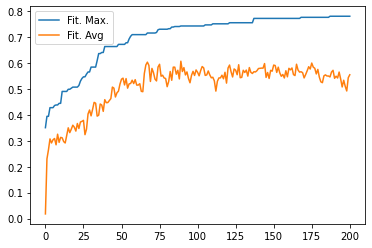

array([0.35699374])

In [24]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(epochs=200,maxReglas=10,plot_fitness=True)
alg.validacion(val,dataTitanic)

## 4.2. Tic-Tac-Toe

Ejecutemos con los mejores hiperparámetros el algoritmo genético con una validación simple y veamos cómo evoluciona el fitness:

Época:  0
Fitness medio:  0.00325678496868476
Fitness del mejor individuo:  0.022964509394572025
Época:  1
Fitness medio:  0.01048016701461378
Fitness del mejor individuo:  0.060542797494780795
Época:  2
Fitness medio:  0.01979123173277662
Fitness del mejor individuo:  0.060542797494780795
Época:  3
Fitness medio:  0.02425887265135699
Fitness del mejor individuo:  0.07306889352818371
Época:  4
Fitness medio:  0.030647181628392486
Fitness del mejor individuo:  0.08977035490605428
Época:  5
Fitness medio:  0.03987473903966597
Fitness del mejor individuo:  0.08977035490605428
Época:  6
Fitness medio:  0.04384133611691023
Fitness del mejor individuo:  0.09394572025052192
Época:  7
Fitness medio:  0.05661795407098121
Fitness del mejor individuo:  0.09394572025052192
Época:  8
Fitness medio:  0.05849686847599165
Fitness del mejor individuo:  0.10855949895615867
Época:  9
Fitness medio:  0.06204592901878916
Fitness del mejor individuo:  0.10855949895615867
Época:  10
Fitness medio:  0.0639665

Época:  41
Fitness medio:  0.5298956158663883
Fitness del mejor individuo:  0.7160751565762005
Época:  42
Fitness medio:  0.5430062630480168
Fitness del mejor individuo:  0.7160751565762005
Época:  43
Fitness medio:  0.4946555323590814
Fitness del mejor individuo:  0.7160751565762005
Época:  44
Fitness medio:  0.4992901878914406
Fitness del mejor individuo:  0.7160751565762005
Época:  45
Fitness medio:  0.5458872651356994
Fitness del mejor individuo:  0.7160751565762005
Época:  46
Fitness medio:  0.5523590814196242
Fitness del mejor individuo:  0.7160751565762005
Época:  47
Fitness medio:  0.5354070981210856
Fitness del mejor individuo:  0.7223382045929019
Época:  48
Fitness medio:  0.5346137787056368
Fitness del mejor individuo:  0.7223382045929019
Época:  49
Fitness medio:  0.5348643006263049
Fitness del mejor individuo:  0.7223382045929019
Época:  50
Fitness medio:  0.5331524008350731
Fitness del mejor individuo:  0.7223382045929019
Época:  51
Fitness medio:  0.5463883089770355
Fitn

Época:  82
Fitness medio:  0.572901878914405
Fitness del mejor individuo:  0.7849686847599165
Época:  83
Fitness medio:  0.5694780793319414
Fitness del mejor individuo:  0.7849686847599165
Época:  84
Fitness medio:  0.5724425887265135
Fitness del mejor individuo:  0.7849686847599165
Época:  85
Fitness medio:  0.5701043841336116
Fitness del mejor individuo:  0.7849686847599165
Época:  86
Fitness medio:  0.6011691022964509
Fitness del mejor individuo:  0.7849686847599165
Época:  87
Fitness medio:  0.5778288100208768
Fitness del mejor individuo:  0.7849686847599165
Época:  88
Fitness medio:  0.6321503131524008
Fitness del mejor individuo:  0.7849686847599165
Época:  89
Fitness medio:  0.6053444676409186
Fitness del mejor individuo:  0.7849686847599165
Época:  90
Fitness medio:  0.5701461377870564
Fitness del mejor individuo:  0.7849686847599165
Época:  91
Fitness medio:  0.5631732776617955
Fitness del mejor individuo:  0.7849686847599165
Época:  92
Fitness medio:  0.5949895615866388
Fitne

Época:  123
Fitness medio:  0.566722338204593
Fitness del mejor individuo:  0.7849686847599165
Época:  124
Fitness medio:  0.5513152400835073
Fitness del mejor individuo:  0.7849686847599165
Época:  125
Fitness medio:  0.5823382045929019
Fitness del mejor individuo:  0.7849686847599165
Época:  126
Fitness medio:  0.5796659707724426
Fitness del mejor individuo:  0.7849686847599165
Época:  127
Fitness medio:  0.5849686847599166
Fitness del mejor individuo:  0.7849686847599165
Época:  128
Fitness medio:  0.5735699373695198
Fitness del mejor individuo:  0.7849686847599165
Época:  129
Fitness medio:  0.5498538622129437
Fitness del mejor individuo:  0.7849686847599165
Época:  130
Fitness medio:  0.5382045929018789
Fitness del mejor individuo:  0.7849686847599165
Época:  131
Fitness medio:  0.5511899791231732
Fitness del mejor individuo:  0.7849686847599165
Época:  132
Fitness medio:  0.5523590814196243
Fitness del mejor individuo:  0.7849686847599165
Época:  133
Fitness medio:  0.56162839248

Época:  164
Fitness medio:  0.5700208768267224
Fitness del mejor individuo:  0.7849686847599165
Época:  165
Fitness medio:  0.5665553235908142
Fitness del mejor individuo:  0.7849686847599165
Época:  166
Fitness medio:  0.582338204592902
Fitness del mejor individuo:  0.7849686847599165
Época:  167
Fitness medio:  0.5577035490605428
Fitness del mejor individuo:  0.7849686847599165
Época:  168
Fitness medio:  0.5648851774530271
Fitness del mejor individuo:  0.7849686847599165
Época:  169
Fitness medio:  0.5743632567849687
Fitness del mejor individuo:  0.7849686847599165
Época:  170
Fitness medio:  0.5866805845511481
Fitness del mejor individuo:  0.7849686847599165
Época:  171
Fitness medio:  0.5586221294363256
Fitness del mejor individuo:  0.7849686847599165
Época:  172
Fitness medio:  0.5716910229645095
Fitness del mejor individuo:  0.7849686847599165
Época:  173
Fitness medio:  0.542045929018789
Fitness del mejor individuo:  0.7849686847599165
Época:  174
Fitness medio:  0.550521920668

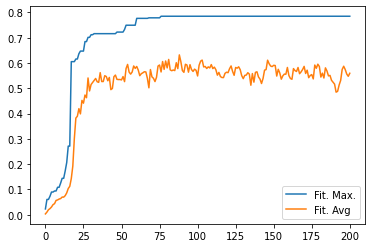

array([0.37787056])

In [3]:
val = ValidacionSimple(0.5)
alg = AlgoritmoGenetico(epochs=200,maxReglas=7,plot_fitness=True)
alg.validacion(val,dataTic)

Como vemos, en este caso el fitness máximo no ha mejorado significativamente desde la época 75, por lo que podríamos haber ejecutado [100,50] y hubiéramos obtenido el mismo resultado. También podemos observar que lo más importante es hacer las 50 primeras épocas, ya que es donde se muestra la mayor mejoría del fitness, con una subida hasta el 0,7. Por otro lado, también vemos que el fitness medio mejora en las primeras épocas, estabilizándose en valores que oscilan el 0,5 y el 0,6 a partir de la época 40.

# 5. Curvas ROC

Para hallar las curvas ROC con Naive-Bayes y nuestro algoritmo genético utilizaremos los hiperparámetros opitimizados de los apartados anteriores. Respecto a Naive-Bayes, el único hiperparámetro digno de mención era si se debía aplicar o no la corrección de laplace. Evidentemente, la utilizaremos, ya que según se demostró en la primera práctica puede o bien no hacer gran cosa o bien mejorar los resultados. A continuación se muestra el código previo de otras prácticas:

In [4]:
import matplotlib.pyplot as plt

# Devuelve los parámetros que interesan de una matriz de confusión a la hora de hacer las curvas ROC
def plot_conf_mat(conf_mat):
    err = (conf_mat[0,1] + conf_mat[1,0])/np.sum(conf_mat)
    tpr = conf_mat[0,0] / np.sum(conf_mat[0])
    fpr = conf_mat[1,0] / np.sum(conf_mat[1])
    x = [0, fpr, 1]
    y = [0, tpr, 1]
    return (x, y, err)

# Muestra las curvas ROC de unos clasificadores escogidos y una cierta base de datos.
def show_roc_curves(clasificadores, datos, proporcionTest=0.3, numeroEjecuciones=1, title='No title'):
    particionado = ValidacionSimple(proporcionTest, numeroEjecuciones)
    errs = np.zeros_like(clasificadores, dtype='float64')
    for i, clsf in enumerate(clasificadores):
        conf_mat= clsf.get_confusion_matrix(particionado,datos)
        x, y, err = plot_conf_mat(conf_mat)
        errs[i] = err
        plt.plot(x, y, label=str(clsf))
    plt.ylabel('sensibilidad')
    plt.xlabel('1 - especificidad')
    plt.title(title)
    plt.legend()
    plt.show()
    return errs

def print_errs(clasificadores,errs):
    for i, clf in enumerate(clasificadores):
        print('Error del clasificador',clf,': ',errs[i]*100,'%')

## 5.1. Titanic

Época:  0
Fitness medio:  0.011862891207153501
Fitness del mejor individuo:  0.36065573770491804
Época:  1
Fitness medio:  0.1170193740685544
Fitness del mejor individuo:  0.38450074515648286
Época:  2
Fitness medio:  0.24616989567809244
Fitness del mejor individuo:  0.38450074515648286
Época:  3
Fitness medio:  0.2831594634873323
Fitness del mejor individuo:  0.4172876304023845
Época:  4
Fitness medio:  0.2812816691505216
Fitness del mejor individuo:  0.4172876304023845
Época:  5
Fitness medio:  0.26852459016393443
Fitness del mejor individuo:  0.4172876304023845
Época:  6
Fitness medio:  0.2689716840536513
Fitness del mejor individuo:  0.4172876304023845
Época:  7
Fitness medio:  0.3024739195230999
Fitness del mejor individuo:  0.4172876304023845
Época:  8
Fitness medio:  0.2650670640834576
Fitness del mejor individuo:  0.4172876304023845
Época:  9
Fitness medio:  0.3205663189269747
Fitness del mejor individuo:  0.44709388971684055
Época:  10
Fitness medio:  0.37716840536512664
Fitne

Época:  41
Fitness medio:  0.4883457526080477
Fitness del mejor individuo:  0.7168405365126677
Época:  42
Fitness medio:  0.5140685543964232
Fitness del mejor individuo:  0.7168405365126677
Época:  43
Fitness medio:  0.4923397913561848
Fitness del mejor individuo:  0.7168405365126677
Época:  44
Fitness medio:  0.4849478390461997
Fitness del mejor individuo:  0.7168405365126677
Época:  45
Fitness medio:  0.5052160953800299
Fitness del mejor individuo:  0.7168405365126677
Época:  46
Fitness medio:  0.5067362146050671
Fitness del mejor individuo:  0.7228017883755589
Época:  47
Fitness medio:  0.5020864381520118
Fitness del mejor individuo:  0.7228017883755589
Época:  48
Fitness medio:  0.5301043219076006
Fitness del mejor individuo:  0.7228017883755589
Época:  49
Fitness medio:  0.5453353204172876
Fitness del mejor individuo:  0.7272727272727273
Época:  50
Fitness medio:  0.505424739195231
Fitness del mejor individuo:  0.7272727272727273
Época:  51
Fitness medio:  0.5345156482861401
Fitne

Época:  82
Fitness medio:  0.5715648286140089
Fitness del mejor individuo:  0.7436661698956781
Época:  83
Fitness medio:  0.5649478390461996
Fitness del mejor individuo:  0.7436661698956781
Época:  84
Fitness medio:  0.5412518628912071
Fitness del mejor individuo:  0.7436661698956781
Época:  85
Fitness medio:  0.5380327868852459
Fitness del mejor individuo:  0.7436661698956781
Época:  86
Fitness medio:  0.5919523099850967
Fitness del mejor individuo:  0.7436661698956781
Época:  87
Fitness medio:  0.5998211624441133
Fitness del mejor individuo:  0.7436661698956781
Época:  88
Fitness medio:  0.5947242921013413
Fitness del mejor individuo:  0.7436661698956781
Época:  89
Fitness medio:  0.5690014903129658
Fitness del mejor individuo:  0.7436661698956781
Época:  90
Fitness medio:  0.5814008941877794
Fitness del mejor individuo:  0.7436661698956781
Época:  91
Fitness medio:  0.5673025335320417
Fitness del mejor individuo:  0.7436661698956781
Época:  92
Fitness medio:  0.5669746646795827
Fitn

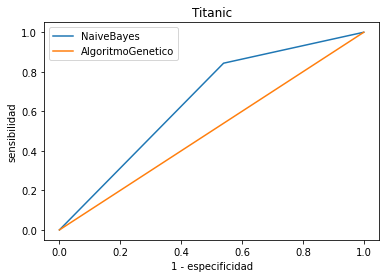

Error del clasificador NaiveBayes :  27.526132404181187 %
Error del clasificador AlgoritmoGenetico :  31.3588850174216 %


In [9]:
clsfNB = ClasificadorNaiveBayes(laplace=True)
clsfAG = AlgoritmoGenetico(maxReglas=10)

clfs = [clsfNB, clsfAG]
errs = show_roc_curves(clfs, dataTitanic, title='Titanic')
print_errs(clfs,errs)

## 5.2. Tic-Tac-Toe

Época:  0
Fitness medio:  0.017108792846497765
Fitness del mejor individuo:  0.3561847988077496
Época:  1
Fitness medio:  0.1667064083457526
Fitness del mejor individuo:  0.36661698956780925
Época:  2
Fitness medio:  0.2708196721311475
Fitness del mejor individuo:  0.368107302533532
Época:  3
Fitness medio:  0.2656929955290611
Fitness del mejor individuo:  0.368107302533532
Época:  4
Fitness medio:  0.23782414307004468
Fitness del mejor individuo:  0.37257824143070045
Época:  5
Fitness medio:  0.31588673621460506
Fitness del mejor individuo:  0.38450074515648286
Época:  6
Fitness medio:  0.28289120715350224
Fitness del mejor individuo:  0.39940387481371087
Época:  7
Fitness medio:  0.30429210134128165
Fitness del mejor individuo:  0.39940387481371087
Época:  8
Fitness medio:  0.3086438152011923
Fitness del mejor individuo:  0.39940387481371087
Época:  9
Fitness medio:  0.3152608047690015
Fitness del mejor individuo:  0.4307004470938897
Época:  10
Fitness medio:  0.29645305514157977
Fit

Época:  41
Fitness medio:  0.5595529061102832
Fitness del mejor individuo:  0.6929955290611028
Época:  42
Fitness medio:  0.5431594634873324
Fitness del mejor individuo:  0.6959761549925484
Época:  43
Fitness medio:  0.5698360655737705
Fitness del mejor individuo:  0.7049180327868853
Época:  44
Fitness medio:  0.5680178837555887
Fitness del mejor individuo:  0.7049180327868853
Época:  45
Fitness medio:  0.504381520119225
Fitness del mejor individuo:  0.7049180327868853
Época:  46
Fitness medio:  0.5219374068554395
Fitness del mejor individuo:  0.7049180327868853
Época:  47
Fitness medio:  0.5459016393442623
Fitness del mejor individuo:  0.7049180327868853
Época:  48
Fitness medio:  0.5197615499254843
Fitness del mejor individuo:  0.7049180327868853
Época:  49
Fitness medio:  0.4798211624441133
Fitness del mejor individuo:  0.7049180327868853
Época:  50
Fitness medio:  0.5218777943368107
Fitness del mejor individuo:  0.7049180327868853
Época:  51
Fitness medio:  0.5340983606557377
Fitne

Época:  82
Fitness medio:  0.5776751117734724
Fitness del mejor individuo:  0.7168405365126677
Época:  83
Fitness medio:  0.5692101341281668
Fitness del mejor individuo:  0.7168405365126677
Época:  84
Fitness medio:  0.5628614008941879
Fitness del mejor individuo:  0.7168405365126677
Época:  85
Fitness medio:  0.5502831594634874
Fitness del mejor individuo:  0.7168405365126677
Época:  86
Fitness medio:  0.5412518628912072
Fitness del mejor individuo:  0.7168405365126677
Época:  87
Fitness medio:  0.5315946348733234
Fitness del mejor individuo:  0.7168405365126677
Época:  88
Fitness medio:  0.5194932935916543
Fitness del mejor individuo:  0.7168405365126677
Época:  89
Fitness medio:  0.5264977645305514
Fitness del mejor individuo:  0.7168405365126677
Época:  90
Fitness medio:  0.4991058122205663
Fitness del mejor individuo:  0.7198211624441133
Época:  91
Fitness medio:  0.5372578241430701
Fitness del mejor individuo:  0.7198211624441133
Época:  92
Fitness medio:  0.552220566318927
Fitne

Época:  123
Fitness medio:  0.532160953800298
Fitness del mejor individuo:  0.7198211624441133
Época:  124
Fitness medio:  0.5426527570789866
Fitness del mejor individuo:  0.7198211624441133
Época:  125
Fitness medio:  0.5347242921013413
Fitness del mejor individuo:  0.7198211624441133
Época:  126
Fitness medio:  0.5568107302533533
Fitness del mejor individuo:  0.7198211624441133
Época:  127
Fitness medio:  0.5166318926974665
Fitness del mejor individuo:  0.7198211624441133
Época:  128
Fitness medio:  0.5425931445603577
Fitness del mejor individuo:  0.7198211624441133
Época:  129
Fitness medio:  0.5411624441132639
Fitness del mejor individuo:  0.7198211624441133
Época:  130
Fitness medio:  0.5310879284649777
Fitness del mejor individuo:  0.7198211624441133
Época:  131
Fitness medio:  0.5130849478390462
Fitness del mejor individuo:  0.7198211624441133
Época:  132
Fitness medio:  0.5324888226527571
Fitness del mejor individuo:  0.7242921013412816
Época:  133
Fitness medio:  0.54631892697

Época:  164
Fitness medio:  0.569478390461997
Fitness del mejor individuo:  0.7436661698956781
Época:  165
Fitness medio:  0.5263189269746646
Fitness del mejor individuo:  0.7436661698956781
Época:  166
Fitness medio:  0.5235171385991059
Fitness del mejor individuo:  0.7436661698956781
Época:  167
Fitness medio:  0.5230998509687034
Fitness del mejor individuo:  0.7436661698956781
Época:  168
Fitness medio:  0.5496274217585693
Fitness del mejor individuo:  0.7436661698956781
Época:  169
Fitness medio:  0.5496274217585693
Fitness del mejor individuo:  0.7436661698956781
Época:  170
Fitness medio:  0.5771684053651267
Fitness del mejor individuo:  0.7436661698956781
Época:  171
Fitness medio:  0.5769299552906111
Fitness del mejor individuo:  0.7436661698956781
Época:  172
Fitness medio:  0.5614008941877794
Fitness del mejor individuo:  0.7436661698956781
Época:  173
Fitness medio:  0.5455737704918033
Fitness del mejor individuo:  0.7436661698956781
Época:  174
Fitness medio:  0.52101341281

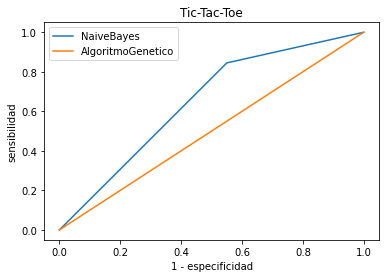

Error del clasificador NaiveBayes :  29.268292682926827 %
Error del clasificador AlgoritmoGenetico :  33.44947735191638 %


In [10]:
clsfNB = ClasificadorNaiveBayes(laplace=True)
clsfAG = AlgoritmoGenetico(epochs=200,maxReglas=7)

clfs = [clsfNB, clsfAG]
errs = show_roc_curves(clfs, dataTic, title='Tic-Tac-Toe')
print_errs(clfs,errs)

No hay lugar a dudas: NaiveBayes es el mejor clasificador en Tic-Tac-Toe. En cuanto al algoritmo genético, se está repitiendo el error observado anteriormente: todo se predice como positivo, por lo que el punto observado es el (1,1). Por lo tanto, el algoritmo genético predice igual que el algoritmo aleatorio en tic-tac-toe.